# Modelo 1 - RF - Processamento individual
1. Verificou-se que o melhor desempenho era com: Remoção de outliers de features (tenham elas skewness ou não);
2. Vamos experimentar mais feature selection, de acordo com o feedback de get_importances do RF;
3. Vamos experimentar normalização, apesar de este algoritmo já possuir alguma.

In [30]:
import re
from collections import Counter
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score, precision_score, recall_score
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings("ignore")

In [31]:
incidentes = pd.read_csv("../input/train_data_cleaned.csv", index_col=0)
teste = pd.read_csv("../input/test_data_cleaned.csv", index_col=0)

## Modelo

In [32]:
#divisão do target
x= incidentes.drop(['incidents'], axis=1)
y= incidentes['incidents']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.87      0.91      0.89       189
           2       0.85      0.83      0.84       144
           3       0.93      0.87      0.90       265
           4       0.89      0.95      0.92       135

    accuracy                           0.93      1250
   macro avg       0.90      0.91      0.91      1250
weighted avg       0.93      0.93      0.93      1250

0.9296


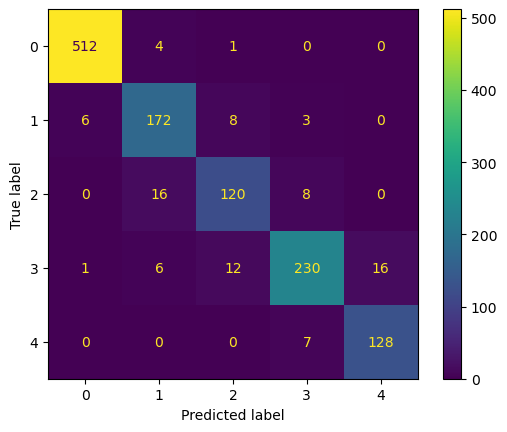

In [34]:
rf_model = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print(classification_report(y_test,rf_pred))
plot_confusion_matrix(rf_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred))

In [35]:
# gera o dataset a submeter na competição
def gerar_submissao(predictions):
    #gerar submissão
    submission = pd.DataFrame(predictions, columns = ["Incidents"])
    submission.insert(0, "RowId", range(1,1207), True)
    submission["Incidents"] = submission['Incidents'].replace({0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}).astype(str)
    submission.to_csv('../output/submission.csv',index=False)
    print("Exported.")

In [36]:
#test_pred = rf_model.predict(teste)
#gerar_submissao(test_pred)

## 1. Normalização - (0,1)


* Pretendemos fazer Feature Selection, apesar de, intuitivamente já termos feito algum;
* Vamos explorar os diferentes métodos conhecidos de normalização, relevante ser feita antes de feature selection, até porque, um dos métodos mais conhecidos, utiliza algoritmos que funcionam melhor com dados normalizados;
* Então, nesta secção, trata-se apenas normalização;
* Dado que o tratamento de outliers não apresentou melhorias em termos de previsão, descartamos esse tratamento e voltamos ao tratamento anterior, com presença de outliers. A boa notícia é a existência de formas de normalização que acabam por reduzir o impacto destes outliers, o que pode melhorar o desempenho do modelo (como é o caso da transformação logarítmica, como veremos);
* A ideia é, então, observar cada feature antes e depois desta normalização, percebendo como cada tipo funciona e se contribui ou não para obtenção de melhores métricas;
* De forma resumida existem 3 tipos de normalização [1]:
    * Normalizar num intervalo, normalmente entre 0 e 1;
        * Resulta bem com:
            * Distribuição normal de dados;
            * Há intuitivamente uma barreira superior/inferior nos dados;
    * Feature Clipping, que remove todos os valores abaixo/acima de um intervalo;
        * Resulta bem com:
            * Existência de muitos outliers extremos (selecionar o intervalo de acordo com os outliers);
            * Pode ser aplicada antes ou depois de outras normalizações;
    * Transformação Log., transforma os valores no seu logaritmo;        
        * Resulta bem com:
            * Distribuição não normal de dados (skewness);
            * Há muitas ocorrências de uma certa classe e poucas de outra;

[1] https://developers.google.com/machine-learning/data-prep/transform/normalization

In [37]:
incidentes.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,Regional,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,15,0,3,23,74,0,0,1
1,0,385,0,12.0,1007.0,91.0,1.0,0,0,1,0,25,5,12,18,359,3,1,1
2,0,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,12,4,3,15,71,0,0,1
3,2,2297,2,15.0,1028.0,75.0,1.0,0,4,10,1,29,2,9,9,272,3,0,1
4,0,0,2,27.0,1020.0,52.0,1.0,0,3,5,0,13,6,6,11,164,1,0,1


In [38]:
teste.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,National,Regional,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0,1211,2,15.0,1018.0,80.0,0.0,0,6.0,0.0,13,1,4,19,103,0,0,1
1,0,0,0,16.0,1018.0,41.0,2.0,0,5.0,0.0,13,2,10,4,286,2,0,1
2,0,0,2,22.0,1017.0,71.0,0.0,0,5.0,0.0,18,6,7,19,199,1,0,1
3,0,140,2,18.0,1008.0,81.0,3.0,0,5.0,1.0,30,5,10,15,303,3,0,1
4,0,0,2,20.0,1022.0,86.0,0.0,0,5.0,0.0,18,0,10,10,291,2,0,1


In [39]:
dict_scalers = {}

scaler = MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

incidentes_norm = incidentes.copy()
teste_norm = teste.copy()
columns = list(incidentes_norm.columns)
columns.remove('incidents')
print(columns)

# fazemos o fit, guardamos o scaler da coluna, aplicamos ao teste
# assim podemos fazer o inverse_transform se necessário, depois.
for col in columns:
    # fit
    scaler_col = min_max_scaler.fit(incidentes_norm[[col]])
    # transform
    incidentes_norm[[col]] = min_max_scaler.transform(incidentes_norm[[col]])
    # guardar scaler no dict
    dict_scalers[col] = scaler_col
    teste_norm[[col]] = dict_scalers.get(col).transform(teste_norm[[col]])

['magnitude_of_delay', 'delay_in_seconds', 'luminosity', 'avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'avg_rain', 'National', 'Regional', 'day_of_month', 'week_day', 'month', 'hour', 'day_of_year', 'season', 'is_holiday', 'is_weekend']


In [40]:
incidentes_norm.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,Regional,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0.0,0.000000,0.0,0.323529,0.457143,0.680851,0.1,0.0,0,0.000000,0.000000,0.466667,0.000000,0.181818,1.000000,0.166189,0.000000,0.0,0.0
1,0.0,0.012386,0.0,0.323529,0.285714,0.904255,0.1,0.0,0,0.023810,0.000000,0.800000,0.833333,1.000000,0.782609,0.982808,1.000000,1.0,0.0
2,0.0,0.002220,1.0,0.382353,0.800000,0.617021,0.0,0.0,1,0.000000,0.000000,0.366667,0.666667,0.181818,0.652174,0.157593,0.000000,0.0,0.0
3,1.0,0.073899,1.0,0.411765,0.885714,0.734043,0.1,0.0,4,0.238095,0.166667,0.933333,0.333333,0.727273,0.391304,0.733524,1.000000,0.0,0.0
4,0.0,0.000000,1.0,0.764706,0.657143,0.489362,0.1,0.0,3,0.119048,0.000000,0.400000,1.000000,0.454545,0.478261,0.424069,0.333333,0.0,0.0


### Segunda avaliação do modelo com normalização

In [41]:
#divisão do target
x_norm = incidentes_norm.drop(['incidents'], axis=1)
y_norm = incidentes_norm['incidents']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.25, random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.87      0.90      0.89       189
           2       0.84      0.82      0.83       144
           3       0.92      0.87      0.90       265
           4       0.88      0.94      0.91       135

    accuracy                           0.93      1250
   macro avg       0.90      0.91      0.90      1250
weighted avg       0.93      0.93      0.93      1250

0.9272


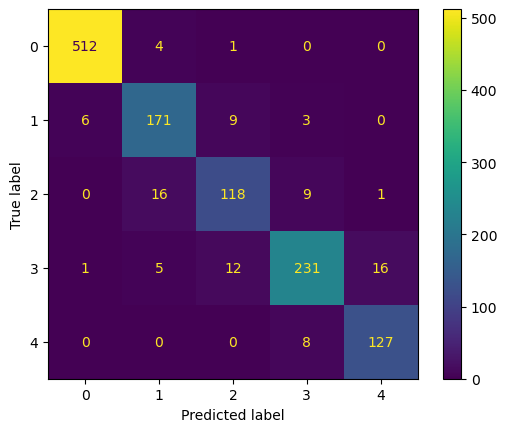

In [43]:
rf_model_norm = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)
rf_model_norm.fit(X_train, y_train)
rf_pred = rf_model_norm.predict(X_test)
print(classification_report(y_test,rf_pred))
plot_confusion_matrix(rf_model_norm,X_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred))

Como era de esperar.

#### Avaliação com Cross-Validation

In [44]:
# Perform 5-fold cross-validation
scores = cross_val_score(rf_model, x, y, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the scores
print(f'Mean accuracy: {scores.mean():.2f}')
print(f'Standard deviation: {scores.std():.2f}')

Mean accuracy: 0.93
Standard deviation: 0.01


## 2 - Feature Importance

In [45]:
# recebe o modelo e os dados de treino e obtém a importância de cada feature
def feature_importance(model, X_train):
    # Get feature importances
    importances = model.feature_importances_
    print(importances)

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = [X_train.columns[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance")

    # Add bars
    plt.bar(range(X_train.shape[1]), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(X_train.shape[1]), names, rotation=90)

    # Show plot
    plt.show()

[0.02937638 0.20135211 0.01048714 0.03156196 0.03936118 0.03253345
 0.01497225 0.00259323 0.14241102 0.00885256 0.07435223 0.02542776
 0.12056268 0.02995694 0.19111078 0.04201631 0.00307201 0.        ]


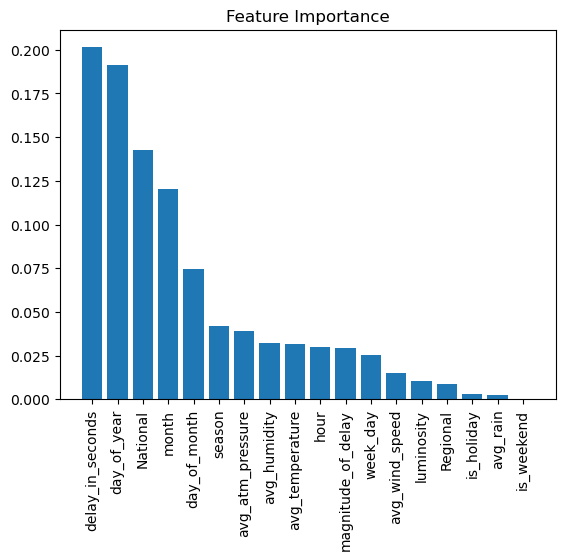

In [46]:
feature_importance(rf_model, X_train)

Verificamos que as features mais importantwes têm um valor de importância superior a 0.025.
Vamos, então, filtrar por este threshold.
O modelo que vamos usar é sem normalização, porque é o melhor até agora.

* th = 0.010

In [47]:
# Crie um objeto SelectFromModel com o modelo treinado e um threshold de importância
sfm = SelectFromModel(rf_model, threshold=0.010)

# Aplique o objeto SelectFromModel ao conjunto de treinamento para selecionar as features mais importantes
X_important_train = sfm.transform(X_train)

# Aplique o mesmo objeto SelectFromModel ao conjunto de teste para selecionar as mesmas features selecionadas no conjunto de treinamento
X_important_test = sfm.transform(X_test)

In [48]:
feature_indices = sfm.get_support(indices=True)
feature_names = X_train.columns[feature_indices]
print(feature_names)

Index(['magnitude_of_delay', 'delay_in_seconds', 'luminosity',
       'avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed',
       'National', 'day_of_month', 'week_day', 'month', 'hour', 'day_of_year',
       'season'],
      dtype='object')


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.89      0.90      0.90       189
           2       0.87      0.85      0.86       144
           3       0.93      0.89      0.91       265
           4       0.90      0.95      0.92       135

    accuracy                           0.94      1250
   macro avg       0.91      0.92      0.91      1250
weighted avg       0.94      0.94      0.94      1250

0.936


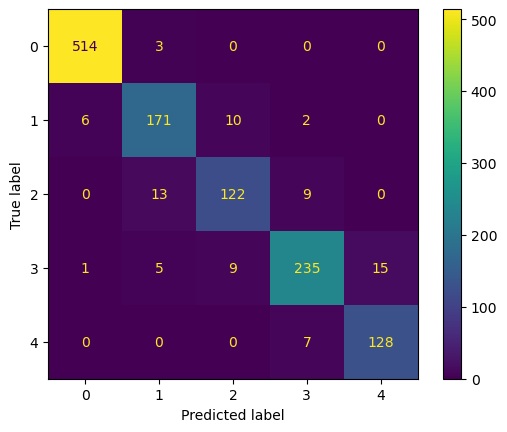

In [49]:
rf_model_10 = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)
rf_model_10.fit(X_important_train, y_train)
rf_pred_10 = rf_model_10.predict(X_important_test)
print(classification_report(y_test,rf_pred_10))
plot_confusion_matrix(rf_model_10,X_important_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred_10))

* th = 0.025

In [50]:
# Crie um objeto SelectFromModel com o modelo treinado e um threshold de importância
sfm1 = SelectFromModel(rf_model, threshold=0.025)

# Aplique o objeto SelectFromModel ao conjunto de treinamento para selecionar as features mais importantes
X_important_train = sfm1.transform(X_train)

# Aplique o mesmo objeto SelectFromModel ao conjunto de teste para selecionar as mesmas features selecionadas no conjunto de treinamento
X_important_test = sfm1.transform(X_test)

In [51]:
feature_indices = sfm1.get_support(indices=True)
feature_names = X_train.columns[feature_indices]
print(feature_names)

Index(['magnitude_of_delay', 'delay_in_seconds', 'avg_temperature',
       'avg_atm_pressure', 'avg_humidity', 'National', 'day_of_month',
       'week_day', 'month', 'hour', 'day_of_year', 'season'],
      dtype='object')


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       517
           1       0.90      0.90      0.90       189
           2       0.86      0.86      0.86       144
           3       0.92      0.88      0.90       265
           4       0.88      0.93      0.91       135

    accuracy                           0.93      1250
   macro avg       0.91      0.91      0.91      1250
weighted avg       0.93      0.93      0.93      1250

0.932


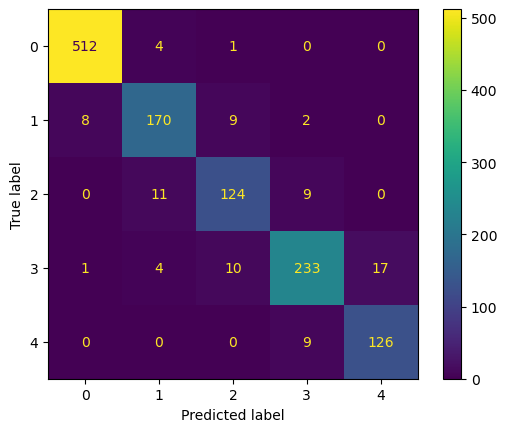

In [52]:
rf_model_25 = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)
rf_model_25.fit(X_important_train, y_train)
rf_pred_25 = rf_model_25.predict(X_important_test)
print(classification_report(y_test,rf_pred_25))
plot_confusion_matrix(rf_model_25,X_important_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred_25))

* th = 0.050

In [53]:
# Crie um objeto SelectFromModel com o modelo treinado e um threshold de importância
sfm2 = SelectFromModel(rf_model, threshold=0.050)

# Aplique o objeto SelectFromModel ao conjunto de treinamento para selecionar as features mais importantes
X_important_train = sfm2.transform(X_train)

# Aplique o mesmo objeto SelectFromModel ao conjunto de teste para selecionar as mesmas features selecionadas no conjunto de treinamento
X_important_test = sfm2.transform(X_test)

In [54]:
feature_indices = sfm2.get_support(indices=True)
feature_names = X_train.columns[feature_indices]
print(feature_names)

Index(['delay_in_seconds', 'National', 'day_of_month', 'month', 'day_of_year'], dtype='object')


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       517
           1       0.89      0.89      0.89       189
           2       0.83      0.83      0.83       144
           3       0.93      0.88      0.91       265
           4       0.89      0.93      0.91       135

    accuracy                           0.93      1250
   macro avg       0.91      0.91      0.91      1250
weighted avg       0.93      0.93      0.93      1250

0.9304


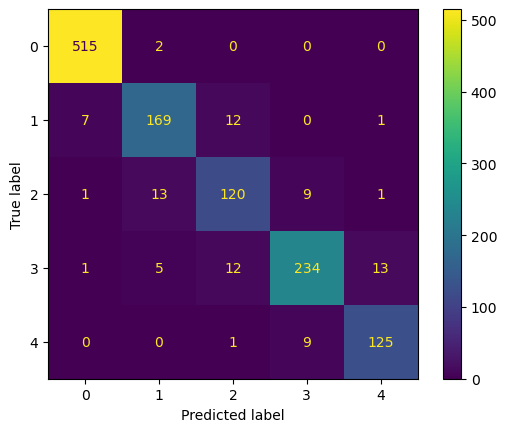

In [55]:
rf_model_50 = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)
rf_model_50.fit(X_important_train, y_train)
rf_pred_50 = rf_model_50.predict(X_important_test)
print(classification_report(y_test,rf_pred_50))
plot_confusion_matrix(rf_model_50,X_important_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred_50))

In [56]:
incidentes.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,Regional,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,15,0,3,23,74,0,0,1
1,0,385,0,12.0,1007.0,91.0,1.0,0,0,1,0,25,5,12,18,359,3,1,1
2,0,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,12,4,3,15,71,0,0,1
3,2,2297,2,15.0,1028.0,75.0,1.0,0,4,10,1,29,2,9,9,272,3,0,1
4,0,0,2,27.0,1020.0,52.0,1.0,0,3,5,0,13,6,6,11,164,1,0,1


### Conclusão

| **Th**    | **Accuracy** | **Features**                                                                                                                                                                                                                                 |
|-----------|--------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **0.010** | **0.9360**   | **['magnitude_of_delay', 'delay_in_seconds', 'luminosity',      'avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed',         'National', 'day_of_month', 'week_day', 'month', 'hour', 'day_of_year',         'season']** |
| 0.025     | 0.932        | ['magnitude_of_delay', 'delay_in_seconds', 'avg_temperature',         'avg_atm_pressure', 'avg_humidity', 'National', 'day_of_month',         'week_day', 'month', 'hour', 'day_of_year', 'season']                                          |
| 0.050     | 0.9304       | ['delay_in_seconds', 'National', 'day_of_month', 'month', 'day_of_year']                                                                                                                                                                     |

In [57]:
incidentes.columns

Index(['magnitude_of_delay', 'delay_in_seconds', 'luminosity',
       'avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed',
       'avg_rain', 'incidents', 'National', 'Regional', 'day_of_month',
       'week_day', 'month', 'hour', 'day_of_year', 'season', 'is_holiday',
       'is_weekend'],
      dtype='object')

Reparamos que as features eliminadas com th de 0.010, foram:
* 'avg_rain'
* 'Regional'
* 'is_holiday'
* 'is_weekend'

O que leva a querer que as features inicialmente adicionadas não contribuem muito para o modelo, mas ainda contribuem, logo vamos manter.

Vamos, agora, fazer tunning ao modelo, seguir para o notebook 4.1